<a href="https://colab.research.google.com/github/efandresena/large-scale-movie-recommendation/blob/main/mirindraf_mlas_practical_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Structure Supporting Genres : **Features**

## Load the data

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-25m.zip

--2026-01-02 08:18:56--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  75.6MB/s    in 3.6s    

2026-01-02 08:18:59 (70.0 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [2]:
feature_path = '/content/ml-25m/movies.csv'
ratings_path = '/content/ml-25m/ratings.csv'

## Createt the dataset

In [3]:
import numpy as np
from numba import njit, prange
import csv
import random

class CompactDatasetCSR:
    """CSR (Compressed Sparse Row) format for efficient matrix operations"""

    def __init__(self, shared_index=None):
        if shared_index is not None:
            self.userId_to_idx, self.idx_to_userId, self.movieId_to_idx, self.idx_to_movieId = shared_index
            self._owns_index = False
        else:
            self.userId_to_idx = {}
            self.idx_to_userId = []
            self.movieId_to_idx = {}
            self.idx_to_movieId = []
            self._owns_index = True

        self._temp_ratings = []
        self.user_indptr = None
        self.user_movie_ids = None
        self.user_ratings = None
        self.movie_indptr = None
        self.movie_user_ids = None
        self.movie_ratings = None
        self._finalized = False

    @property
    def usr_size(self):
        return len(self.idx_to_userId)

    @property
    def movie_size(self):
        return len(self.idx_to_movieId)

    def get_shared_index(self):
        return (self.userId_to_idx, self.idx_to_userId,
                self.movieId_to_idx, self.idx_to_movieId)

    def add_rating(self, userId, movieId, rating_value):
        if self._finalized:
            raise RuntimeError("Cannot add ratings after finalization")

        if self._owns_index:
            if userId not in self.userId_to_idx:
                self.userId_to_idx[userId] = len(self.idx_to_userId)
                self.idx_to_userId.append(userId)
            if movieId not in self.movieId_to_idx:
                self.movieId_to_idx[movieId] = len(self.idx_to_movieId)
                self.idx_to_movieId.append(movieId)

        user_pos = self.userId_to_idx.get(userId)
        movie_pos = self.movieId_to_idx.get(movieId)

        if user_pos is not None and movie_pos is not None:
            self._temp_ratings.append((user_pos, movie_pos, rating_value))

    def add_genres_features(self, filepath):
        """Build genre features in CSR format"""
        self.genre2id = {}
        movie_idx_to_genres = {}

        with open(filepath, 'r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                movieId, _, genres = row
                if movieId not in self.movieId_to_idx:
                    continue

                movie_idx = self.movieId_to_idx[movieId]
                genre_names = genres.strip().split('|')
                genre_ids = []

                for g in genre_names:
                    if g not in self.genre2id:
                        self.genre2id[g] = len(self.genre2id)
                    genre_ids.append(self.genre2id[g])

                movie_idx_to_genres[movie_idx] = genre_ids

        # Build CSR format for genres
        N = self.movie_size
        self.movie_genre_indptr = np.zeros(N + 1, dtype=np.int64)
        genre_list = []

        for movie_idx in range(N):
            genres = movie_idx_to_genres.get(movie_idx, [])
            self.movie_genre_indptr[movie_idx + 1] = self.movie_genre_indptr[movie_idx] + len(genres)
            genre_list.extend(genres)

        self.movie_genre_ids = np.array(genre_list, dtype=np.int32)
        self.num_genres = len(self.genre2id)

    def finalize(self):
        if self._finalized:
            return

        print(f"Finalizing dataset ({len(self._temp_ratings)} ratings)...")
        M, N = self.usr_size, self.movie_size

        # Build user CSR
        self._temp_ratings.sort(key=lambda x: (x[0], x[1]))
        self.user_indptr = np.zeros(M + 1, dtype=np.int64)
        self.user_movie_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.user_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_user = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            while current_user < user_idx:
                current_user += 1
                self.user_indptr[current_user] = idx
            self.user_movie_ids[idx] = movie_idx
            self.user_ratings[idx] = rating
        self.user_indptr[M] = len(self._temp_ratings)

        # Build movie CSR
        self._temp_ratings.sort(key=lambda x: (x[1], x[0]))
        self.movie_indptr = np.zeros(N + 1, dtype=np.int64)
        self.movie_user_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.movie_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_movie = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            while current_movie < movie_idx:
                current_movie += 1
                self.movie_indptr[current_movie] = idx
            self.movie_user_ids[idx] = user_idx
            self.movie_ratings[idx] = rating
        self.movie_indptr[N] = len(self._temp_ratings)

        self._temp_ratings = None
        self._finalized = True
        print(f"✓ Users={M}, Movies={N}, Ratings={len(self.user_ratings)}")


def load_data(filepath, test_ratio=0.2, seed=42):
    """Load dataset with train/test split"""
    random.seed(seed)
    train = CompactDatasetCSR()
    test = CompactDatasetCSR(shared_index=train.get_shared_index())

    print("Loading data...")
    with open(filepath, 'r') as file:
        next(file)
        for line in file:
            userId, movieId, rating, _ = line.strip().split(',')
            rating = float(rating)
            if random.random() < test_ratio:
                test.add_rating(userId, movieId, rating)
            else:
                train.add_rating(userId, movieId, rating)

    train.finalize()
    test.finalize()
    return train, test


@njit(parallel=True, fastmath=True)
def update_user_biases_and_factors(user_biases, u, item_biases, v,
                                   user_indptr, user_movie_ids, user_ratings,
                                   lamda, gamma, k):
    M = len(user_biases)
    for m in prange(M):
        start = user_indptr[m]
        end = user_indptr[m + 1]
        omega = end - start

        if omega == 0:
            continue

        # Update user bias
        numerator = 0.0
        for idx in range(start, end):
            n = user_movie_ids[idx]
            r = user_ratings[idx]
            pred_no_bias = 0.0
            for d in range(k):
                pred_no_bias += u[m, d] * v[n, d]
            numerator += r - item_biases[n] - pred_no_bias
        user_biases[m] = lamda * numerator / (lamda * omega + gamma)

        # Update user latent factors
        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)

        for idx in range(start, end):
            n = user_movie_ids[idx]
            r = user_ratings[idx]
            for i in range(k):
                for j in range(k):
                    A[i, j] += v[n, i] * v[n, j]
            residual = r - user_biases[m] - item_biases[n]
            for i in range(k):
                b[i] += v[n, i] * residual

        for i in range(k):
            for j in range(k):
                A[i, j] *= lamda
            A[i, i] += gamma
            b[i] *= lamda

        u[m, :] = np.linalg.solve(A, b)


@njit(parallel=True, fastmath=True)
def update_item_biases_and_factors(item_biases, v, user_biases, u, f,
                                   movie_indptr, movie_user_ids, movie_ratings,
                                   movie_genre_indptr, movie_genre_ids,
                                   lamda, gamma, k):
    N = len(item_biases)
    for n in prange(N):
        start = movie_indptr[n]
        end = movie_indptr[n + 1]
        omega = end - start

        if omega == 0:
            continue

        # Update item bias
        numerator = 0.0
        for idx in range(start, end):
            m = movie_user_ids[idx]
            r = movie_ratings[idx]
            pred_no_bias = 0.0
            for d in range(k):
                pred_no_bias += v[n, d] * u[m, d]
            numerator += r - user_biases[m] - pred_no_bias
        item_biases[n] = lamda * numerator / (lamda * omega + gamma)

        # Update item latent factors
        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)

        for idx in range(start, end):
            m = movie_user_ids[idx]
            r = movie_ratings[idx]
            for i in range(k):
                for j in range(k):
                    A[i, j] += u[m, i] * u[m, j]
            residual = r - user_biases[m] - item_biases[n]
            for i in range(k):
                b[i] += u[m, i] * residual

        for i in range(k):
            for j in range(k):
                A[i, j] *= lamda
            A[i, i] += gamma
            b[i] *= lamda

        # Add genre prior
        g_start = movie_genre_indptr[n]
        g_end = movie_genre_indptr[n + 1]
        F_n = g_end - g_start

        if F_n > 0:
            for idx_g in range(g_start, g_end):
                g = movie_genre_ids[idx_g]
                for i in range(k):
                    b[i] += gamma * f[g, i] / F_n

        v[n, :] = np.linalg.solve(A, b)


@njit(parallel=True, fastmath=True)
def update_genre_factors(f, v, movie_genre_indptr, movie_genre_ids, k):
    num_genres = f.shape[0]
    num_movies = v.shape[0]
    f_new = np.zeros_like(f)

    for g in prange(num_genres):
        numerator = np.zeros(k, dtype=np.float32)
        denominator = 0.0

        for n in range(num_movies):
            start = movie_genre_indptr[n]
            end = movie_genre_indptr[n + 1]
            F_n = end - start
            if F_n == 0:
                continue

            sqrt_Fn = np.sqrt(F_n)
            contains_g = False
            sum_other_fk = np.zeros(k, dtype=np.float32)

            for idx in range(start, end):
                genre_id = movie_genre_ids[idx]
                if genre_id == g:
                    contains_g = True
                else:
                    sum_other_fk += f[genre_id, :]

            if contains_g:
                numerator += (v[n, :] - sum_other_fk / sqrt_Fn) / sqrt_Fn
                denominator += 1.0 / F_n

        f_new[g, :] = numerator / (denominator + 1e-10)

    for g in range(num_genres):
        for i in range(k):
            f[g, i] = f_new[g, i]


@njit(parallel=True, fastmath=True)
def compute_metrics_numba(user_indptr, user_movie_ids, user_ratings,
                          user_biases, item_biases, u, v, f,
                          movie_genre_indptr, movie_genre_ids, gamma):
    M = len(user_biases)
    k = u.shape[1]

    sq_errors = np.zeros(M, dtype=np.float64)
    counts = np.zeros(M, dtype=np.int64)

    for m in prange(M):
        start = user_indptr[m]
        end = user_indptr[m + 1]
        local_sq_err = 0.0
        for idx in range(start, end):
            n = user_movie_ids[idx]
            r = user_ratings[idx]
            pred = user_biases[m] + item_biases[n]
            for d in range(k):
                pred += u[m, d] * v[n, d]
            diff = r - pred
            local_sq_err += diff * diff
        sq_errors[m] = local_sq_err
        counts[m] = end - start

    sq_err = np.sum(sq_errors)
    count = np.sum(counts)

    reg_term = gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2) +
                        np.sum(u ** 2) + np.sum(v ** 2))

    # Genre prior term
    N = v.shape[0]
    genre_reg = 0.0
    for n in range(N):
        start_g = movie_genre_indptr[n]
        end_g = movie_genre_indptr[n + 1]
        F_n = end_g - start_g
        if F_n > 0:
            sum_fk = np.zeros(k, dtype=np.float32)
            for idx_g in range(start_g, end_g):
                g = movie_genre_ids[idx_g]
                sum_fk += f[g, :]
            diff_v = v[n, :] - sum_fk / F_n
            genre_reg += np.sum(diff_v ** 2)

    reg_term += gamma * (genre_reg + np.sum(f ** 2))
    loss = 0.5 * (sq_err + reg_term)
    rmse = np.sqrt(sq_err / count) if count > 0 else 0.0

    return loss, rmse


def train_als(train, test, k=2, lamda=0.1, gamma=0.5, epochs=5):
    M, N = train.usr_size, train.movie_size
    G = train.num_genres

    # Initialize
    norm_f = 1.0 / np.sqrt(k)
    user_biases = np.zeros(M, dtype=np.float32)
    item_biases = np.zeros(N, dtype=np.float32)
    u = norm_f * np.random.randn(M, k).astype(np.float32)
    v = norm_f * np.random.randn(N, k).astype(np.float32)
    f = norm_f * np.random.randn(G, k).astype(np.float32)

    print(f"\nTraining: {M} users, {N} movies, {G} genres, k={k}")

    for epoch in range(epochs):
        update_user_biases_and_factors(
            user_biases, u, item_biases, v,
            train.user_indptr, train.user_movie_ids, train.user_ratings,
            lamda, gamma, k
        )

        update_item_biases_and_factors(
            item_biases, v, user_biases, u, f,
            train.movie_indptr, train.movie_user_ids, train.movie_ratings,
            train.movie_genre_indptr, train.movie_genre_ids,
            lamda, gamma, k
        )

        update_genre_factors(f, v, train.movie_genre_indptr, train.movie_genre_ids, k)

        loss_tr, rmse_tr = compute_metrics_numba(
            train.user_indptr, train.user_movie_ids, train.user_ratings,
            user_biases, item_biases, u, v, f,
            train.movie_genre_indptr, train.movie_genre_ids, gamma
        )

        loss_te, rmse_te = compute_metrics_numba(
            test.user_indptr, test.user_movie_ids, test.user_ratings,
            user_biases, item_biases, u, v, f,
            test.movie_genre_indptr, test.movie_genre_ids, gamma
        )

        print(f"Epoch {epoch+1:2d}: Loss(tr)={loss_tr:.4f} Loss(te)={loss_te:.4f} "
              f"RMSE(tr)={rmse_tr:.4f} RMSE(te)={rmse_te:.4f}")

    return user_biases, item_biases, u, v, f


In [4]:
## Training
train, test = load_data(ratings_path)
train.add_genres_features(feature_path)
test.add_genres_features(feature_path)
user_biases, item_biases, u, v, f = train_als(train, test,15,0.1,0.5,20 )

Loading data...
Finalizing dataset (19999499 ratings)...
✓ Users=162541, Movies=56713, Ratings=19999499
Finalizing dataset (4945733 ratings)...
✓ Users=162541, Movies=56713, Ratings=4945733

Training: 162541 users, 56713 movies, 20 genres, k=15
Epoch  1: Loss(tr)=7249721.6454 Loss(te)=2535518.9913 RMSE(tr)=0.8214 RMSE(te)=0.9066
Epoch  2: Loss(tr)=6138792.9865 Loss(te)=2253282.0660 RMSE(tr)=0.7542 RMSE(te)=0.8536
Epoch  3: Loss(tr)=5627377.1810 Loss(te)=2086040.3779 RMSE(tr)=0.7228 RMSE(te)=0.8250
Epoch  4: Loss(tr)=5388660.3645 Loss(te)=1994482.7777 RMSE(tr)=0.7088 RMSE(te)=0.8120
Epoch  5: Loss(tr)=5258359.0772 Loss(te)=1936624.3393 RMSE(tr)=0.7018 RMSE(te)=0.8054
Epoch  6: Loss(tr)=5175400.9323 Loss(te)=1894750.6111 RMSE(tr)=0.6978 RMSE(te)=0.8014
Epoch  7: Loss(tr)=5116849.9149 Loss(te)=1862215.7144 RMSE(tr)=0.6952 RMSE(te)=0.7988
Epoch  8: Loss(tr)=5072908.3683 Loss(te)=1836002.3393 RMSE(tr)=0.6934 RMSE(te)=0.7969
Epoch  9: Loss(tr)=5038524.6198 Loss(te)=1814414.3960 RMSE(tr)=0.69

## Save the model

In [7]:
final_model_path = "final_model.npz"
np.savez(final_model_path,
    user_biases=user_biases,
    item_biases=item_biases,
    u=u,
    v=v,
    f=f,
    #params
    k=15,
    lamda=0.1,
    gamma=0.5,
    dataset=test # for the movie index prediction

)

In [9]:
# Copy the model to drive
!cp final_model.npz /content/drive/MyDrive/BLOC#3/ML_at_Large_Scale

## Dummy user : Predict

The dummy user will be the same as we had in practical 4.

In [53]:

class DummyUser:
    def __init__(self, rated_movies, k ):
        """
        num_movies: total number of movies
        rated_movies: list of tuples (movie_idx, rating) # here we have the movie idx
        k: latent dimension
        """
        self.k = k

        # Ratings
        self.movie_idx = [movie_idx for movie_idx, _ in rated_movies]
        self.ratings = {movie_idx: rating for movie_idx, rating in rated_movies}

        # Latent vector and bias
        norm_k = 1/np.sqrt(self.k)
        self.u = norm_k*np.random.normal(scale=0.1, size=(1,k)).astype(np.float32)
        self.bias = 0.0

    def score_for_item(self):
        """Predict ratings the user will give to all the movies embedding .
          Output: """
        scores = self.u.dot(self.v.T) + 0.05 * self.item_biases # regularize the term bias
        return scores

    def update(self, v, item_biases, lamda=0.1, gamma=0.1):
        """
        movie_factors: array of shape (N, k)
        item_biases: array of shape (N,) vector
        """
        k = self.k
        self.v = v
        self.item_biases = item_biases
        # get the number of movie the dummy user rated:
        omega = len(self.movie_idx)
        if omega == 0:
            return
        # update bias
        numerator = 0.0
        for m_idx in self.movie_idx:
            r = self.ratings[m_idx]
            uv = (self.u @ v[m_idx]).item()
            numerator += r - item_biases[m_idx] - uv
        self.bias = lamda * numerator / (lamda * omega + gamma)

        # update latent vector

        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)
        for m_idx in self.movie_idx:
            r = self.ratings[m_idx]
            v_m = v[m_idx]
            A += np.outer(v_m, v_m)
            residual = r - self.bias - item_biases[m_idx]
            b += v_m * residual

        A = lamda * A + gamma * np.eye(k, dtype=np.float32)
        b = lamda * b
        self.u = np.linalg.solve(A, b)[None, :]

def predict(user: DummyUser, m:int): #  where m is the number of suggestions
  # Embedds the new user in a latent trait vector
  user.update(v,item_biases,lamda,gamma)
  a = user.score_for_item()[0]

  #first ten  best possible
  sorted_idx = np.argsort(a)
  a[sorted_idx][-m:]
  best = sorted_idx[-m:]

  ID = index_to_movie_Id(test, best)
  less_rating = check_if_less_rating(train, best)
  new_bests = [idx for idx in best if idx not in less_rating][::-1]
  ID_new_best = index_to_movie_Id(train, new_bests)
  return ID_new_best

### Helper functions

In [33]:
# Index to Id and Id to Index for movie
from ast import List

def index_to_movie_Id(dataset: CompactDatasetCSR, indexes:List):
  ids = []
  for idx in indexes:
    id = dataset.idx_to_movieId[idx]
    ids.append(id)
  return ids

def movie_id_to_idx(dataset: CompactDatasetCSR, IDs:List):
  indexes = []
  for id in IDs:
    idx = dataset.movieId_to_idx[str(id)]
    indexes.append(idx)
  return indexes

def check_if_less_rating(train: CompactDatasetCSR,  bests):
  idx_to_remove = []
  # count the number of rating an index has
  c = 0
  limit = 100
  for idx in bests:
    m = idx
    start = train.movie_indptr[m]
    end = train.movie_indptr[m + 1]
    if end-start<=limit:
      idx_to_remove.append(idx)
      c+=1
  print(f"{c} movies having number of ratings less than {limit}.")
  return idx_to_remove

  ## Printing

def pretty_print_recommendations(func):
    def wrapper(pd_movies, ID):
        print("\n" + "="*50)
        print("                 MOVIE RECOMMENDATION")
        print("="*50 + "\n")
        func(pd_movies, ID)
        print("\n" + "="*50)
    return wrapper


@pretty_print_recommendations
def get_movie_info(pd_movies, ID):
    for idx, movie_id in enumerate(ID, start=1):

        row = pd_movies.loc[pd_movies['movieId'] == int(movie_id)].iloc[0]

        # Tag for top 3 recommendations
        tag = " 🔥 MUST WATCH!" if idx <= 3 else ""

        print(f"{idx}. {row['title']}{tag}")
        print(f"   Genres: {row['genres']}\n")

### Loading the model

In [13]:
# suppose we load the model :
data = np.load("final_model.npz", allow_pickle=True) # need pickle to load the object dataset

v = data["v"]
item_biases = data["item_biases"]
k = data["k"]
lamda = data["lamda"]
gamma = data["gamma"]
test = data["dataset"].item()

# Test with Toy Story 4

In [29]:
idx = movie_id_to_idx(test, [201588])

In [34]:
# The new user data and its embeddings
rated_movies = [(idx[0],5.0)]# list of tuples [(movies_idx, ratings)]

# Create dummy user
user = DummyUser(rated_movies, k)

In [35]:
import pandas as pd

movies_path = "/content/ml-25m/movies.csv"
movies = pd.read_csv(movies_path)

ID_new_best = predict(user, 20)
get_movie_info(movies, ID_new_best) # we need movies pandas dataframe

0 movies having number of ratings less than 100.

                 MOVIE RECOMMENDATION

1. Beauty and the Beast (1991) 🔥 MUST WATCH!
   Genres: Animation|Children|Fantasy|Musical|Romance|IMAX

2. Toy Story (1995) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy

3. Toy Story 3 (2010) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX

4. Babe (1995)
   Genres: Children|Drama

5. Little Mermaid, The (1989)
   Genres: Animation|Children|Comedy|Musical|Romance

6. Toy Story 2 (1999)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

7. Aladdin (1992)
   Genres: Adventure|Animation|Children|Comedy|Musical

8. Inside Out (2015)
   Genres: Adventure|Animation|Children|Comedy|Drama|Fantasy

9. Finding Nemo (2003)
   Genres: Adventure|Animation|Children|Comedy

10. Monsters, Inc. (2001)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

11. Lilo & Stitch (2002)
   Genres: Adventure|Animation|Children|Sci-Fi

12. Incredibles, The (2004)
   G

## Test with : *Lord of the Rings 1*

In [39]:
idx = movie_id_to_idx(test, [4993])
# The new user data and its embeddings
rated_movies = [(idx[0],5.0)]# list of tuples [(movies_idx, ratings)]

# Create dummy user
user = DummyUser(rated_movies, k)
movies = pd.read_csv(movies_path)

ID_new_best = predict(user, 20)
get_movie_info(movies, ID_new_best)

0 movies having number of ratings less than 100.

                 MOVIE RECOMMENDATION

1. Lord of the Rings: The Return of the King, The (2003) 🔥 MUST WATCH!
   Genres: Action|Adventure|Drama|Fantasy

2. Lord of the Rings: The Two Towers, The (2002) 🔥 MUST WATCH!
   Genres: Adventure|Fantasy

3. Lord of the Rings: The Fellowship of the Ring, The (2001) 🔥 MUST WATCH!
   Genres: Adventure|Fantasy

4. Hobbit: The Desolation of Smaug, The (2013)
   Genres: Adventure|Fantasy|IMAX

5. Hobbit: An Unexpected Journey, The (2012)
   Genres: Adventure|Fantasy|IMAX

6. The Hobbit: The Battle of the Five Armies (2014)
   Genres: Adventure|Fantasy

7. Star Wars: Episode I - The Phantom Menace (1999)
   Genres: Action|Adventure|Sci-Fi

8. Harry Potter and the Half-Blood Prince (2009)
   Genres: Adventure|Fantasy|Mystery|Romance|IMAX

9. Harry Potter and the Deathly Hallows: Part 1 (2010)
   Genres: Action|Adventure|Fantasy|IMAX

10. Harry Potter and the Order of the Phoenix (2007)
   Genres: Advent

## Mixing genres taste of a User


If we mix the genres of films the users like we should recommend different gerne to the user also

In [55]:
idx = movie_id_to_idx(test, [1, 3, 44, 142925])
movies[movies['movieId'].isin([1, 3, 44, 142925])][['title', 'genres']]

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
43,Mortal Kombat (1995),Action|Adventure|Fantasy
33341,A Christmas Horror Story (2015),Horror


In [56]:
rated_movies = [(idx[0],5.0),(idx[1],5.0),(idx[2],5.0),(idx[3],5.0)]
# Create dummy user
user = DummyUser(rated_movies, k)
ID_new_best = predict(user,20)

#predict
get_movie_info(movies, ID_new_best)

0 movies having number of ratings less than 100.

                 MOVIE RECOMMENDATION

1. Mortal Kombat (1995) 🔥 MUST WATCH!
   Genres: Action|Adventure|Fantasy

2. Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991) 🔥 MUST WATCH!
   Genres: Action|Children|Fantasy

3. Pokémon: The First Movie (1998) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Fantasy|Sci-Fi

4. Mighty Morphin Power Rangers: The Movie (1995)
   Genres: Action|Children

5. Brady Bunch Movie, The (1995)
   Genres: Comedy

6. Teenage Mutant Ninja Turtles (1990)
   Genres: Action|Children|Comedy|Fantasy|Sci-Fi

7. Bio-Dome (1996)
   Genres: Comedy

8. Karate Kid, Part III, The (1989)
   Genres: Action|Adventure|Children|Drama

9. D3: The Mighty Ducks (1996)
   Genres: Children|Comedy

10. D2: The Mighty Ducks (1994)
   Genres: Children|Comedy

11. Space Jam (1996)
   Genres: Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi

12. Barb Wire (1996)
   Genres: Action|Sci-Fi

13. Mighty Ducks, The (1992)

# Plot of the rmse test

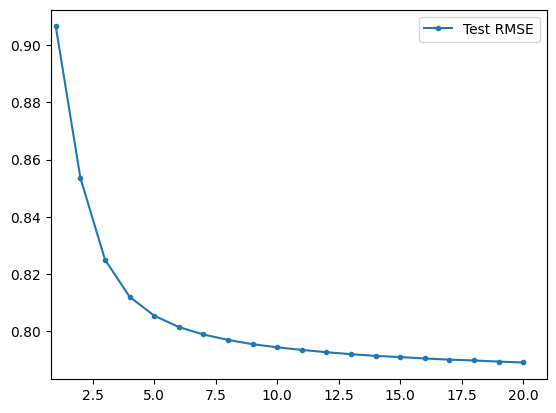

In [49]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))


rmse_te = [
    0.9066, 0.8536, 0.8250, 0.8120, 0.8054,
    0.8014, 0.7988, 0.7969, 0.7954, 0.7943,
    0.7934, 0.7926, 0.7919, 0.7913, 0.7909,
    0.7904, 0.7900, 0.7897, 0.7893, 0.7890
]

plt.figure()

plt.plot(epochs, rmse_te, label="Test RMSE",marker='.')

plt.legend()
plt.xlim(left=min(rmse_te))
plt.savefig("final_rmse_test.pdf")
plt.show()
